# Classification of crystallography images

(but using cats and dogs for now)

In [59]:
# numpy and plotting
import numpy as np
import matplotlib.pyplot as plt
import os, glob
%matplotlib inline

# Settings

In [77]:
datapath = '../../../../2018_IMB_DeepLearning/data/cats_vs_dogs/train/'

height, width = 92, 92

# Load image data


In [89]:

# get filenames for images of each class
fns_cats = glob.glob(os.path.join(datapath, 'cats', '*.jpg'))
fns_dogs = glob.glob(os.path.join(datapath, 'dogs', '*.jpg'))

# throw away 75% of the dog filenames to induce class imbalance
fns_dogs = fns_dogs[:len(fns_dogs)//4]


## Read image data

In [160]:
def read_image(fn, imsize):
    from skimage import io, transform, color
    im = io.imread(fn)
    im = color.rgb2gray(im)
    im = transform.resize(im, imsize, mode='constant')
    im = im[..., np.newaxis] # add empty channels axis
    return im

In [161]:
#ims_cats = np.array([read_image(fn, (height, width)) for fn in fns_cats])

# read in cat images (using parallelization to speed up loading)
from joblib import Parallel, delayed
ims_cats = np.array( Parallel(n_jobs=-1)(delayed(read_image)(fn, (height, width)) for fn in fns_cats))
ims_cats.shape

# read in dog images (using parallelization to speed up loading)
ims_dogs = np.array( Parallel(n_jobs=-1)(delayed(read_image)(fn, (height, width)) for fn in fns_dogs))
ims_dogs.shape

(125, 92, 92, 1)

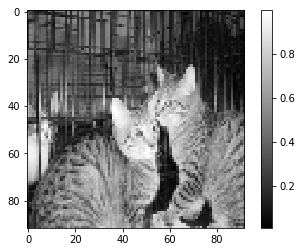

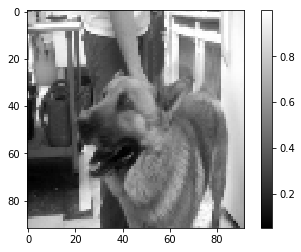

In [163]:
plt.imshow(np.squeeze(ims_cats[0]), cmap='gray')
plt.colorbar()
plt.show()

plt.imshow(np.squeeze(ims_dogs[0]), cmap='gray')
plt.colorbar()
plt.show()


In [164]:
# combine the two images classes
x = np.concatenate([ims_cats, ims_dogs], axis=0)

# construct labels from the number of files in each class
y = np.array([0]*len(ims_cats) + [1]*len(ims_dogs))

print(x.shape)
print(y.shape)

(625, 92, 92, 1)
(625,)


## Split in train and test set

In [165]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)#, random_state=42)

# Compute class weights to address class imbalance

The class with the smallest number of sample should get high weight.
Note: here we take `y` rather than `y_train`.

In [166]:
np.unique(y, return_counts=True)

(array([0, 1]), array([500, 125]))

In [167]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(np.squeeze(y)), np.squeeze(y))
class_weights

array([0.625, 2.5  ])

# Convolutional network model

- take InceptionV3, without pretrained weights, without dense top 
- InceptionV3 probably an overkill for the data, but we can tune the model down later

In [168]:
def construct_model():
    from keras.applications import InceptionV3
    from keras.models import Model
    from keras.layers import Dense
    model = InceptionV3(input_shape=(None, None, 1), 
                        weights=None, 
                        include_top=False, 
                        pooling='max')
    
    
    x = Dense(256, activation='relu')(model.output)
    x = Dense(128, activation='relu')(model.output)
    o = Dense(1, activation='sigmoid')(x)
    return Model(inputs=model.input, outputs=o)

model = construct_model()
#model.summary()

In [169]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
#SVG(model_to_dot(model, rankdir='LR').create(prog='dot', format='svg'))

# Loss function

- to counter large class imbalance in samples

In [170]:
def focal_loss(gamma=2., alpha=.25):
    '''
    Loss function for binary classification with large class imbalance.
    Based on binary crossentropy, but it focuses on hard examples instead and less on easy samples.   
    
    Paper: https://arxiv.org/pdf/1708.02002.pdf
    Keras implementation: https://github.com/mkocabas/focal-loss-keras/blob/master/focal_loss.py
    '''
    import tensorflow as tf
    import keras.backend as K 
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

# Data augmentation

In [171]:
def generate_batch(batch_size, rotation=True):
    
    while True:
        
        # take random sample from x_train
        samples_ind = np.random.randint(low=0, high=len(x_train), size=batch_size)
        x_batch = x_train[samples_ind]
        y_batch = y_train[samples_ind]
        
        for i in range(batch_size):
            if rotation:
                rotations = np.random.randint(0,3)
                x_batch[i] = np.rot90(x_batch[i], k=rotations)
            
        yield x_batch, y_batch
        

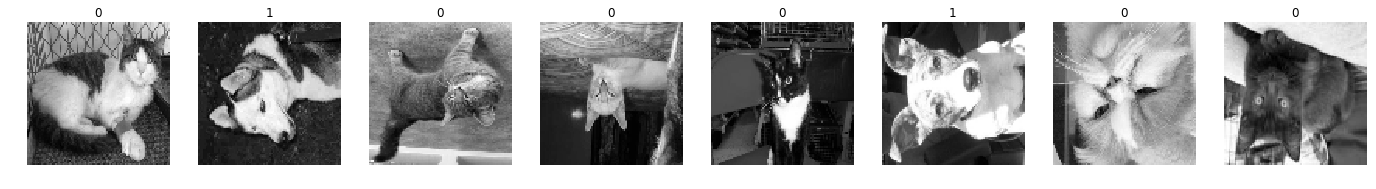

In [173]:
# test data augmentation
n=8
x_batch, y_batch = next(generate_batch(n))

fig, ax = plt.subplots(1,n, figsize=(n*3, 3))
for i, a in enumerate(ax.flatten()):
    a.imshow(np.squeeze(x_batch[i]), cmap='gray')
    a.set_title(y_batch[i])
    a.axis('off')

# Compile

with focal loss where alpha is set to the inverse class frequency computed above

In [174]:
gamma = 2.0  # see section 3.2 of https://arxiv.org/pdf/1708.02002.pdf
alpha = class_weights[0] 
model.compile(optimizer='adam', 
              loss=focal_loss(gamma=gamma, alpha=alpha), 
              metrics=['accuracy'])

# Train

In [178]:
batch_size = 4
epochs = 10

train_generator = generate_batch(batch_size=batch_size)
test_generator  = generate_batch(batch_size=batch_size, rotation=False)

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=len(x_train) // batch_size,
                              epochs=epochs, 
                              validation_data=test_generator,
                              validation_steps=len(x_test) // batch_size)
# class_weight = dict(enumerate(class_weight))

Epoch 1/10
117/117 [==============================] - 154s 1s/step - loss: 0.5669 - acc: 0.6902 - val_loss: 0.3699 - val_acc: 0.7692
Epoch 2/10
 19/117 [===>..........................] - ETA: 1:17 - loss: 0.3966 - acc: 0.5789

KeyboardInterrupt: 

# Predict

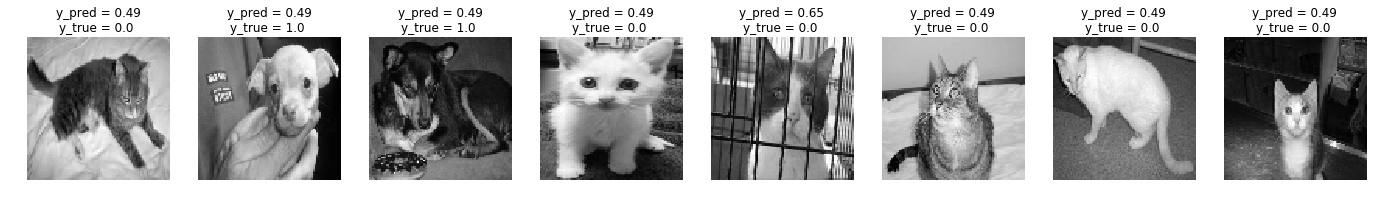

In [187]:
n = 8
y_pred = model.predict(x_test[:8])

fig, ax = plt.subplots(1,n, figsize=(n*3, 3))
for i, a in enumerate(ax.flatten()):
    a.imshow(np.squeeze(x_test[i]), cmap='gray')
    a.set_title('y_pred = {:.2f}\ny_true = {:.1f} '.format(y_pred[i][0], y_test[i]))
    a.axis('off')